# The model for star clusters

In [1]:
import two_phase_galaxy_model as tpgm
import numpy as np
from pyhipp import plot
from pyhipp.io import h5
from pyhipp.astro.cosmology.model import LambdaCDM

## A simple example

Here we define a subhalo merger tree. It should be defined as a `dict`, with 
each value being an array of a given property of all subhalos, satisfying:
- DFS ordered (i.e. output of SubLink, as used in TNG);
- containing the required fields (see the doc string of `make_group_tree_from_dict`).

The `dict` is parsed by the shortcut function `make_group_tree_from_dict` that 
transforms the data types and evaluates other required properties. A data 
container is returned, which can be used as the input of the model.

Note that the processing unit of the model is a subhalo merger tree.
For multiple trees, transform them one-by-one and store them, e.g. in a list.

In [2]:
subhalos = {
    'id': [10, 11, 12, 13, 14, 
               15, 16, 17, 18,
                       19, 20],
    'leaf_id': [14, 14, 14, 14, 14,
                    18, 18, 18, 18,
                            20, 20],
    'last_pro_id': [20, 14, 14, 14, 14,
                        20, 20, 18, 18,
                                20, 20],
    'snap': [99, 97, 80, 70, 55,
                 97, 80, 70, 55,
                         70, 55],
    'z': [0.0, 1.0, 2.0, 3.0, 4.0,
               1.0, 2.0, 3.0, 4.0,
                         3.0, 4.0],
    'is_cent': [True, True,  True, False, True,
                      False, True, True,  True,
                                   True,  True],
    'm_h': [10**2.5, 10**2.0, 10**1.5, 0.0,     10**0.5,
                     0.0,     10**1.0, 10**1.0, 10**0.5,
                                       10**0.5, 10**-0.5],
    'v_max': [10**2.8, 10**2.2, 10**1.7, 10**1.6, 10**1.5,
                       10**1.9, 10**1.7, 10**1.6, 10**1.5,
                                         10**1.5, 10**1.0],
}
data_in = tpgm.samples.make_group_tree_from_dict(subhalos)

A schematic figure for this tree is shown below:

![tree](example_data/subhalo-tree.png)

We contruct the model for the formation of star clusters:

In [3]:
model = tpgm.model.GroupTreeModel()

All the model parameters can be seen by calling `iter_parameter()`. 
Here we display the first 5 parameters:

In [4]:
params = list(model.iter_parameters())
params[:5]

[(galaxies_in_group_tree.cvt_stellar_mzr, array(False)),
 (galaxies_in_group_tree.f_r_lb, array(0.01)),
 (galaxies_in_group_tree.force_mzr, array(False)),
 (galaxies_in_group_tree.solar_oxygen, array(8.75)),
 (galaxies_in_group_tree.stellar_mzr_src, array(0))]

The model is implemented in a nested way. 
- We can get any sub-model from the attribute access.
- Sub-model has similar API, e.g. `iter_parameters()`.

In [5]:
sc_sampler = model.subclouds_in_group_tree.samplers
params = list(sc_sampler.iter_parameters())
params[:10]

[(alpha_s, array(1.5)),
 (beta, array(1.)),
 (beta_m, array(-2.)),
 (beta_metal, array(0.75)),
 (beta_metalp, array(-0.75)),
 (beta_mp, array(-0.75)),
 (beta_n_sf, array(-2.5)),
 (beta_n_sfp, array(-0.75)),
 (beta_sp, array(-1.25)),
 (bias_lmetal, array(0.))]

Here we update some of the parameters by the method `update_parameters()`. 
- The argument is a `dict`.
- The key of the dict can be the name of a parameter, and the value is the new one to update.
- The key can also be the name of a sub-model, and the value is a `dict` of name-value pairs for the parameters to update.

This makes it easy to order the parameters in a config file (e.g. JSON or YAML),
and update the parameters in a single call.

After all parameters are set, call `set_up()`. This will prepare and cache the data
required for the model. JIT is made to speed up the calculation.
Do not frequently call `set_up()` as it can be time-consuming.  

In [6]:
model.update_parameters({
    'subclouds_in_group_tree.samplers.beta_m': -2.,
})
model.update_parameters({
    'subclouds_in_group_tree.samplers': {
        'alpha_s': 2.0,
        'beta_n_sf': -3.0,
    }
})
model.set_up()

We pass the data to the model, and get the result. 
The result has two attributes: 
- `sc_set`: the set of sub-clouds (i.e. star-clusters) formed throughout the merger tree. 
- `grptr`: the set of subhalos (i.e. galaxies), ordered the same as the input data.

The first execution of `model()` takes more time as JIT compiles the code to machine natives.
The subsequent calls will be much faster.

In [7]:
data_out = model(data_in)
data_out

Result(grptr={ 'type': 'GroupTree',
  'size': 11,
  'keys': [ 'id', 'leaf_id', 'last_pro_id', 'id_in_branch', 'id_in_subtr',
            'id_in_grptr', 'snap', 'z', 'a', 't_lb', 'x_t', 'big_hubble', 'dt',
            'm_h', 'dm_h', 'r_h', 'v_h', 'v_max', 'is_cent', 'is_fast', 'gamma',
            'f_en', 'f_sn', 'f_agn', 'm_g', 'dm_g_hot', 'dm_g_cool', 'dm_g_sf',
            'dm_g_ej', 'dm_g_prev', 'dm_g', 'r_sgc', 'm_s', 'dm_s', 'sfr',
            'm_s_d', 'm_s_b', 'm_bh', 'dm_bh', 'bh_seeded', 'm_Z', 'dm_Z',
            'dm_Z_yield', 'dm_Z_ej', 'dm_Z_lock', 'Z'],
  'n_subtrs': 1}, sc_set={ 'type': 'SubcloudSet',
  'size': 6946,
  'keys': [ 'subhalo_id_in_grptr', 'snap', 'z', 'Z', 'n_sgc', 'n_sampled',
            'n_sf', 'n_shield', 'n_adopted', 'weight', 'm_g', 'rho_g', 'r_g',
            'm_s', 'r_s', 'u_r', 'r', 'm_s_final']})

Both `grptr` and `sc_set` are wrappers of numpy array of structured records.
You can access a column by `[column_name]`, or access a row by `[index]`.

Instead, use `sc_set.data` and `grptr.data` to visit the numpy array directly.

In [8]:
data_out.grptr['m_s'], data_out.sc_set['m_s'], data_out.sc_set[0]

(array([2.5057846e+01, 2.0212698e+00, 5.5505890e-02, 1.0281696e-02,
        5.2318890e-03, 6.8317257e-02, 4.2551361e-02, 1.1543645e-02,
        5.2952301e-03, 1.8561432e-03, 6.3069712e-04], dtype=float32),
 array([2.2400757e-08, 9.0167816e-07, 1.0825435e-05, ..., 1.5542734e-06,
        7.7194200e-05, 3.0908198e-03], dtype=float32),
 { 'subhalo_id_in_grptr': 0,
   'snap': 99,
   'z': 0.0,
   'Z': 0.8645902,
   'n_sgc': 0.5290865,
   'n_sampled': 300.4304,
   'n_sf': 1.8193585,
   'n_shield': 1.7685361,
   'n_adopted': 300.4304,
   'weight': 39097.742,
   'm_g': 7.466919e-07,
   'rho_g': 1941682600.0,
   'r_g': 4.511194e-06,
   'm_s': 2.2400757e-08,
   'r_s': 2.255597e-06,
   'u_r': 0.5013143,
   'r': 0.0015921243,
   'm_s_final': 2.2400757e-08})

Here we draw the mass function of star clusters that are born in SN-free sub-clouds:

- `m_s_final` is the final stellar mass of the star cluster at the root snapshot of the subhalo merger tree.
- `m_s` is the initial (birth-time) stellar mass.

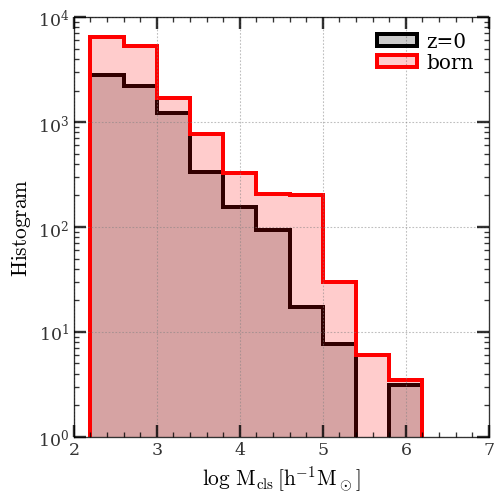

In [9]:
def show_mass_function(data_out):
    m_s_final, m_s, n_sc, w = data_out.sc_set['m_s_final', 'm_s', 'n_adopted', 'weight']
    is_snfree = n_sc > 10**3.5
    m_s_final = m_s_final[is_snfree] * 1.0e10   # to h^{-1} M_sun
    m_s = m_s[is_snfree] * 1.0e10
    w = w[is_snfree]

    fig, ax = plot.subplots(1, figsize=5.5)

    kw = dict(range=(1.,7.), bins=15, weights=w, log=True, lw=3)
    ax.c('k').hist(np.log10(m_s_final.clip(1.)), **kw, label='z=0')\
        .c('r').hist(np.log10(m_s.clip(1.)), **kw, label='born')
        
    ax.lim([2., 7.], [1., 1.0e4]).leg()\
        .label(r'\log\,M_{\rm cls}\,[h^{-1}M_\odot]', r'\rm Histogram')
        
show_mass_function(data_out)

## A realistic example

Here we show a more realistic example where we work on a merger tree taken
from the IllustrisTNG100-1-Dark simulation.

The data is donwloaded from "https://www.tng-project.org/", and we have 
converted them into a HDF5 file containing data required by our model.

The data is a subhalo merger tree rooted in a subhalo with 
`SubhaloID=30000308700000000` (see IllustrisTNG's doc, sometimes this ID is 
also called SubLinkID). The halo mass of the root subhalo is about $10^{11} h^{-1} M_\odot$.

To quickly view the file contents, we use the `pyhipp.io.h5` module:

In [10]:
file_name = 'example_data/example_tree.hdf5'
h5.File.ls_from(file_name)

/
├─ cosmology_params/
   ├─ hubble(float64)
   ├─ n_spec(float64)
   ├─ omega_b0(float64)
   ├─ omega_l0(float64)
   ├─ omega_m0(float64)
   ├─ sigma_8(float64)
   └─ t_cmb(float64)
└─ subhalos/
   ├─ id(int64, (1005,))
   ├─ is_cent(bool, (1005,))
   ├─ last_pro_id(int64, (1005,))
   ├─ leaf_id(int64, (1005,))
   ├─ m_h(float32, (1005,))
   ├─ snap(int16, (1005,))
   ├─ v_max(float32, (1005,))
   └─ z(float64, (1005,))


The file contains subhalos in the merger tree, as well as 
the cosmological parameters used in the simulation.

To load the data, call `load_from()`. It returns a dict-like 
object, whose values can be accessed by keys:

In [11]:
cosm_ps, subhalos = h5.File.load_from(file_name)[
    'cosmology_params', 'subhalos']

Here we plot the main-branch mass assembly history of the root subhalo:

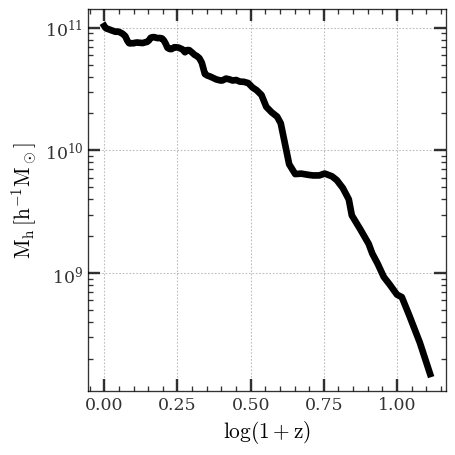

In [12]:
fig, ax = plot.subplots(1, figsize=5)

m_h, z, leaf_id, id =  subhalos['m_h', 'z', 'leaf_id', 'id']
leaf_off = leaf_id[0] - id[0]
m_h, z = m_h[:leaf_off+1], z[:leaf_off+1]

ax.plot(np.log10(1.+z), m_h * 1.0e10, lw=5)

ax.scale(y='log').label(r'\log(1+z)', r'M_{\rm h}\,[h^{-1}M_\odot]')

We convert the data to the format that the model expects, and run the model:

In [13]:
cosm = LambdaCDM.from_parameters(cosm_ps)
data_in = tpgm.samples.make_group_tree_from_dict(subhalos, cosm=cosm)

model = tpgm.model.GroupTreeModel()
model.set_up()

data_out = model(data_in)

We again show the mass function of star clusters:

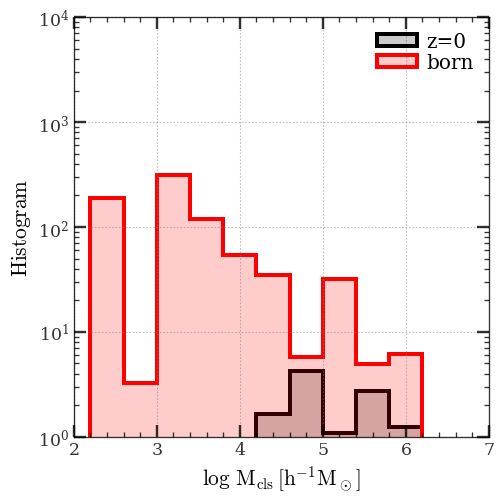

In [14]:
show_mass_function(data_out)